In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM


Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

(828, 10)
(828,)


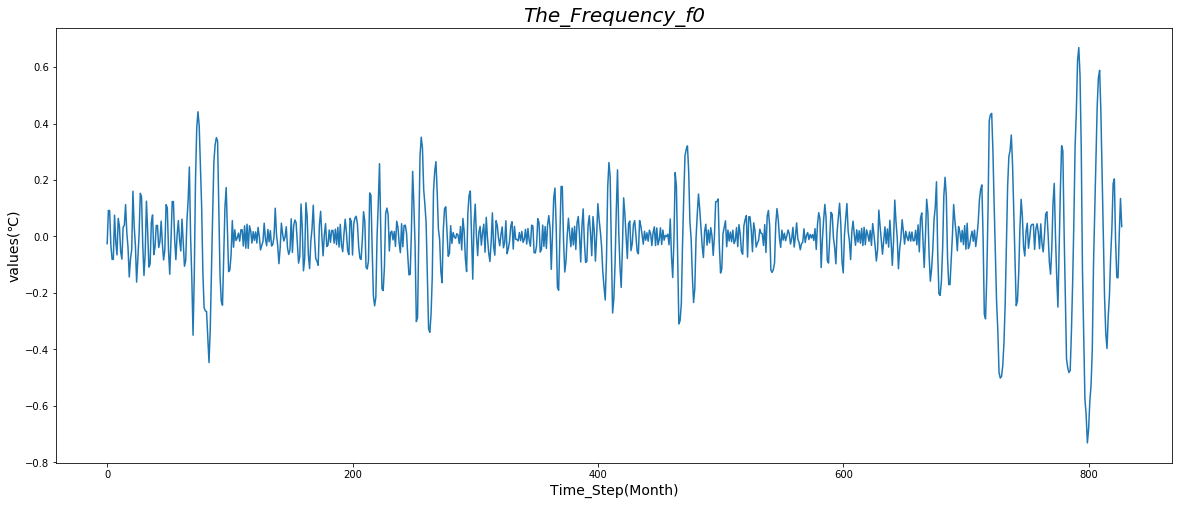

[[[-0.28373  ]
  [-0.20753  ]
  [-0.069358 ]
  [ 0.029479 ]
  [ 0.18765  ]
  [ 0.20383  ]
  [-0.017003 ]
  [-0.14515  ]
  [-0.14641  ]
  [ 0.0092768]
  [ 0.1346   ]
  [ 0.035037 ]]]
[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
(792, 24, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 15s - loss: 0.0220
Epoch 2/200
 - 5s - loss: 0.0217
Epoch 3/200
 - 18s - loss: 0.0214
Epoch 4/200
 - 6s - loss: 0.0210
Epoch 5/200
 - 6s - loss: 0.0203
Epoch 6/200
 - 6s - loss: 0.0192
Epoch 7/200
 - 6s - loss: 0.0176
Epoch 8/200
 - 5s - loss: 0.0175
Epoch 9/200
 - 5s - loss: 0.0171
Epoch 10/200
 - 5s - loss: 0.0166
Epoch 11/200
 - 5s - loss: 0.0160
Epoch 12/200
 - 5s - loss: 0.0153
Epoch 13/200
 - 5s - loss: 0.0155
Ep

the prediction values are:[[ 0.07907514]
 [-0.01809913]
 [-0.13244478]
 [-0.18707097]
 [-0.16719389]
 [-0.08573839]
 [ 0.01417866]
 [ 0.08386122]
 [ 0.10050503]
 [ 0.071152  ]
 [ 0.02213629]
 [-0.01944342]]
the real values are:[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
12
[-0.28373]
[[0.07907514]]
0.13162756619324703
12
[-0.20753]
[[-0.01809913]]
0.03588405481205323
12
[-0.069358]
[[-0.13244478]]
0.003979942321168151
12
[0.029479]
[[-0.18707097]]
0.04689388767364848
12
[0.18765]
[[-0.16719389]]
0.12591418599917453
12
[0.20383]
[[-0.08573839]]
0.08384985288339568
12
[-0.017003]
[[0.01417866]]
0.000972295673498032
12
[-0.14515]
[[0.08386122]]
0.05244613746727055
12
[-0.14641]
[[0.10050503]]
0.060967032852398524
12
[0.0092768]
[[0.071152]]
0.00382854057543385
12
[0.1346]
[[0.02213629]]
0.012648086988925947
12
[0.035037]
[[-0.01944342]]
0.0029681164418719737
(67, 12)
(840,)


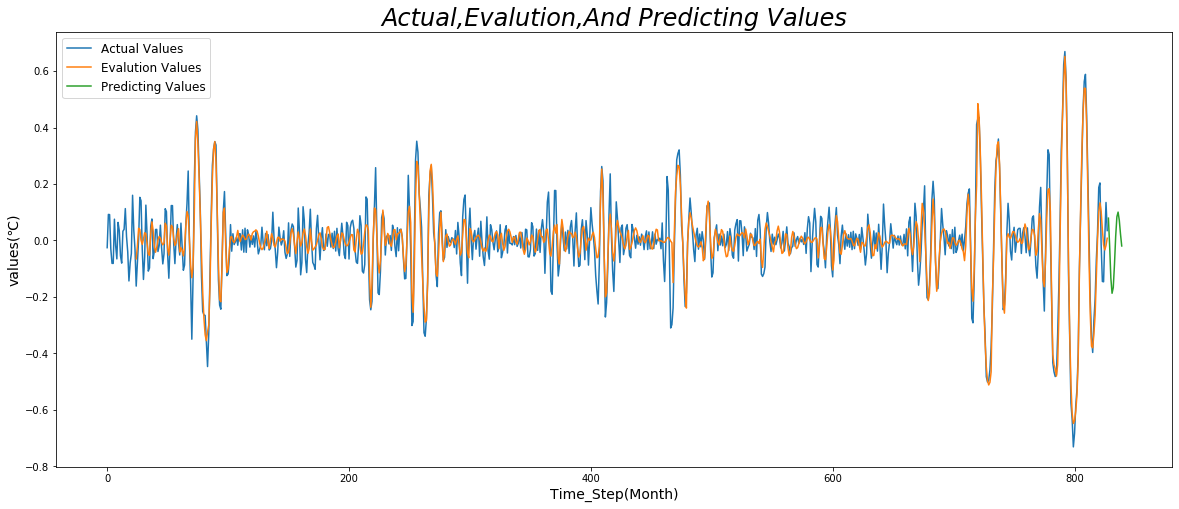

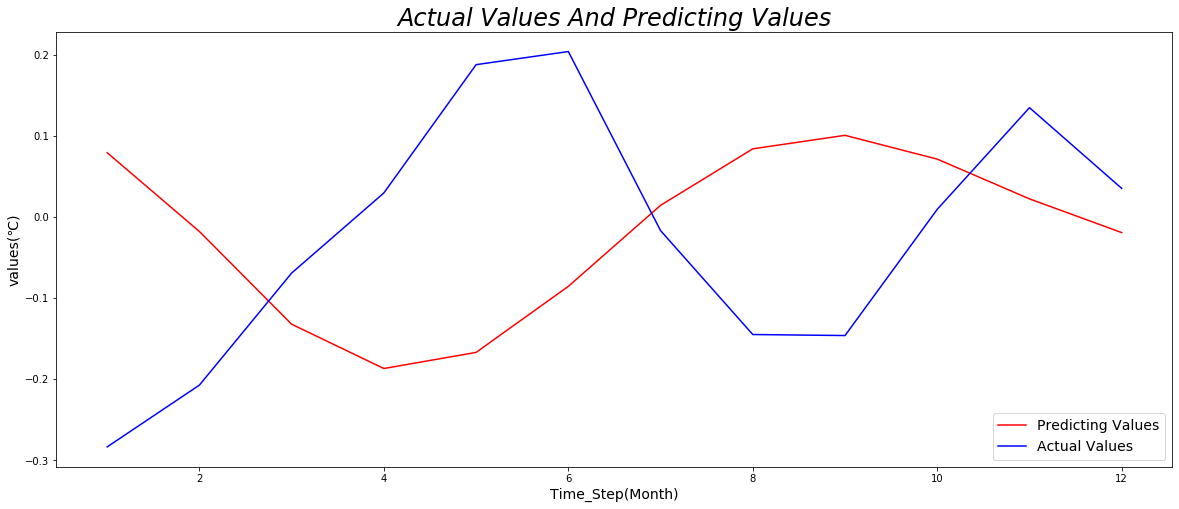

(828,)


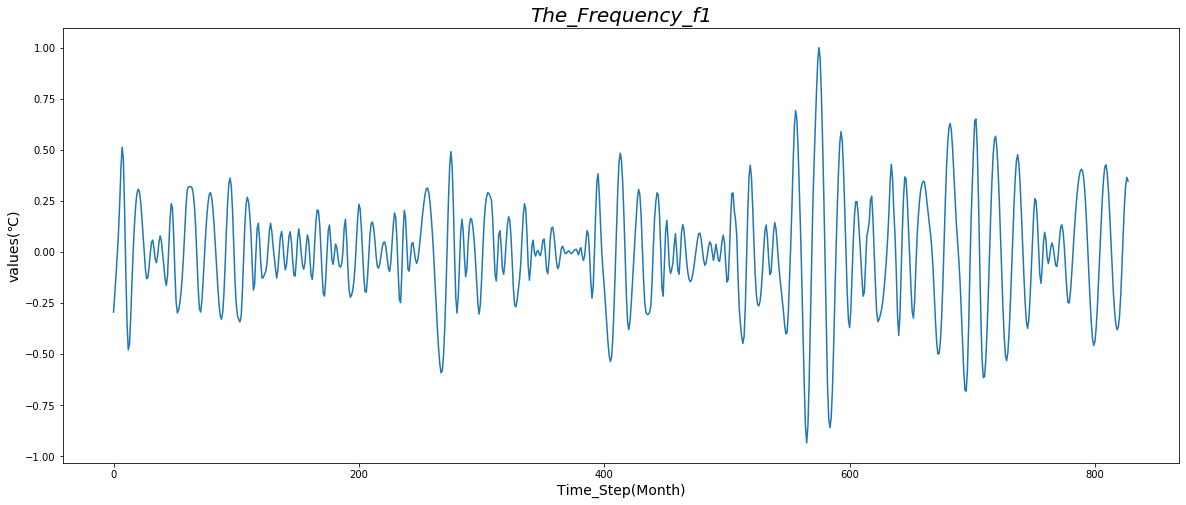

[[[-0.29143 ]
  [-0.354   ]
  [-0.38141 ]
  [-0.36968 ]
  [-0.31534 ]
  [-0.21508 ]
  [-0.071875]
  [ 0.086582]
  [ 0.22809 ]
  [ 0.32458 ]
  [ 0.36537 ]
  [ 0.34646 ]]]
[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
(792, 24, 1)
Epoch 1/200
 - 22s - loss: 0.0638
Epoch 2/200
 - 6s - loss: 0.0564
Epoch 3/200
 - 6s - loss: 0.0491
Epoch 4/200
 - 6s - loss: 0.0431
Epoch 5/200
 - 6s - loss: 0.0412
Epoch 6/200
 - 6s - loss: 0.0394
Epoch 7/200
 - 6s - loss: 0.0391
Epoch 8/200
 - 6s - loss: 0.0372
Epoch 9/200
 - 6s - loss: 0.0370
Epoch 10/200
 - 6s - loss: 0.0351
Epoch 11/200
 - 6s - loss: 0.0339
Epoch 12/200
 - 5s - loss: 0.0348
Epoch 13/200
 - 5s - loss: 0.0328
Epoch 14/200
 - 6s - loss: 0.0336
Epoch 15/200
 - 6s - loss: 0.0324
Epoch 16/200
 - 6s - loss: 0.0312
Epoch 17/200
 - 6s - loss: 0.0317
Epoch 18/200
 - 5s - loss: 0.0319
Epoch 19/200
 - 6s - loss: 0.0297
Epoch 20/200
 - 6s - loss: 0.0287
Epoch 21/200
 - 5s - l

(67, 12)
(840,)


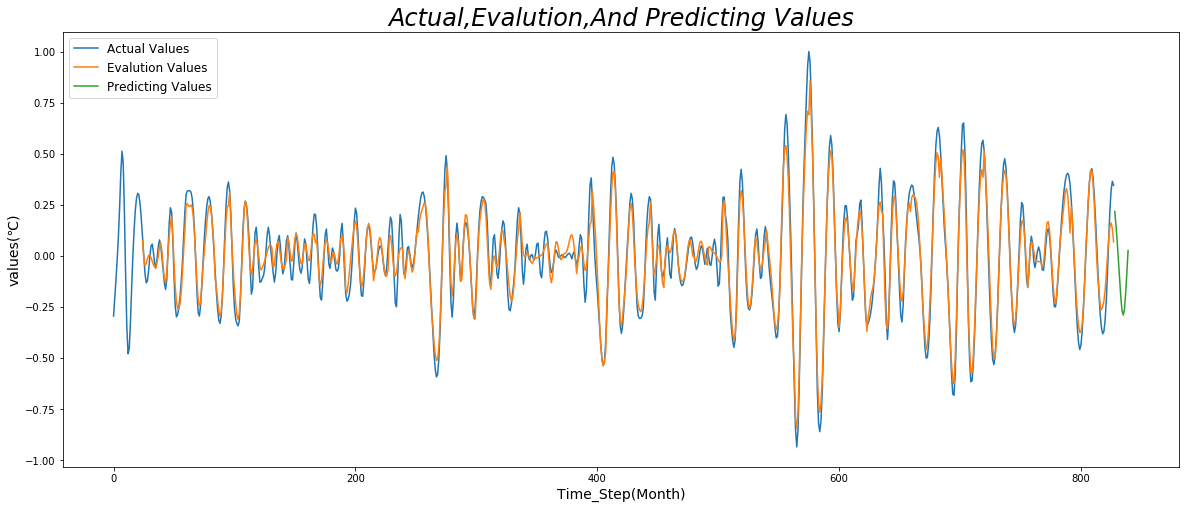

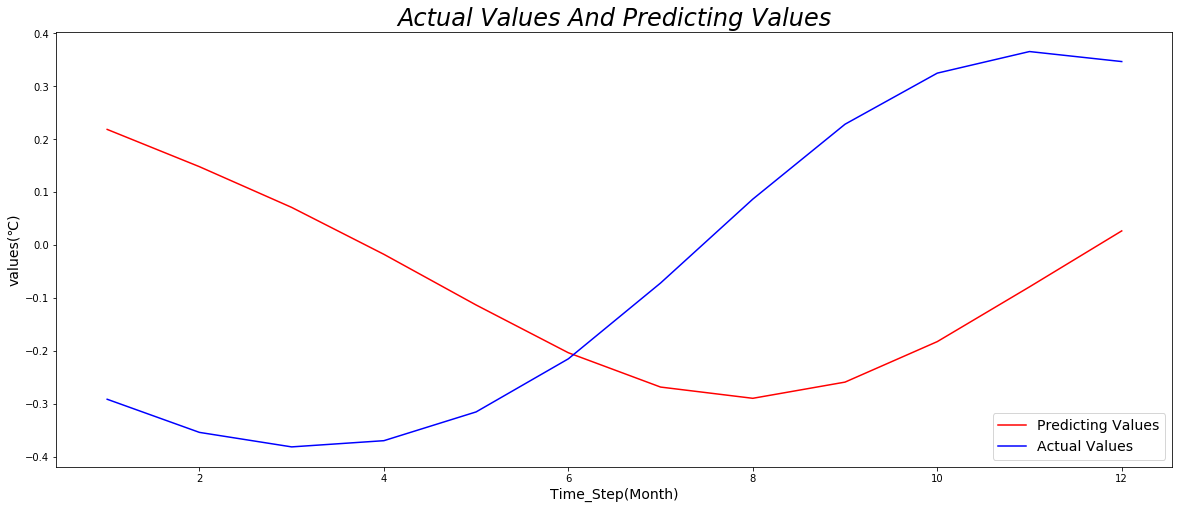

(828,)


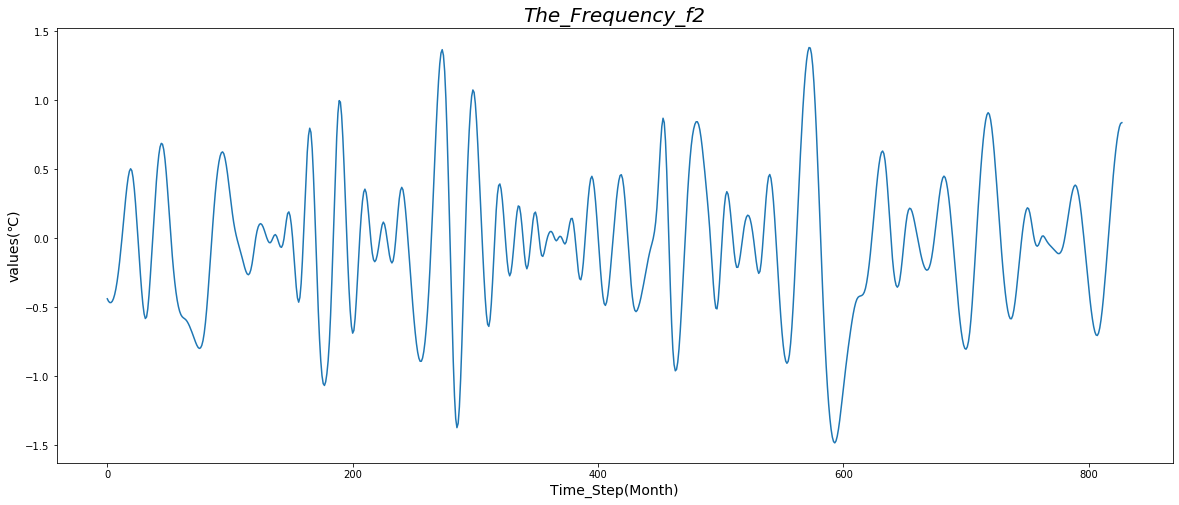

[[[0.0056482]
  [0.12307  ]
  [0.23839  ]
  [0.34909  ]
  [0.45314  ]
  [0.54868  ]
  [0.63381  ]
  [0.70665  ]
  [0.76531  ]
  [0.80793  ]
  [0.83261  ]
  [0.83806  ]]]
[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70665   0.76531   0.80793   0.83261   0.83806  ]
(792, 24, 1)
Epoch 1/200
 - 26s - loss: 0.2392
Epoch 2/200
 - 7s - loss: 0.2178
Epoch 3/200
 - 7s - loss: 0.2055
Epoch 4/200
 - 7s - loss: 0.1629
Epoch 5/200
 - 9s - loss: 0.1233
Epoch 6/200
 - 9s - loss: 0.1198
Epoch 7/200
 - 7s - loss: 0.1108
Epoch 8/200
 - 12s - loss: 0.0977
Epoch 9/200
 - 7s - loss: 0.0926
Epoch 10/200
 - 13s - loss: 0.0810
Epoch 11/200
 - 8s - loss: 0.0931
Epoch 12/200
 - 7s - loss: 0.0811
Epoch 13/200
 - 8s - loss: 0.0768
Epoch 14/200
 - 7s - loss: 0.0733
Epoch 15/200
 - 7s - loss: 0.0730
Epoch 16/200
 - 7s - loss: 0.0688
Epoch 17/200
 - 7s - loss: 0.0601
Epoch 18/200
 - 7s - loss: 0.0606
Epoch 19/200
 - 7s - loss: 0.0603
Epoch 20/200
 - 7s - loss: 0.0580
Epoch 21/200
 - 7s - l

(67, 12)
(840,)


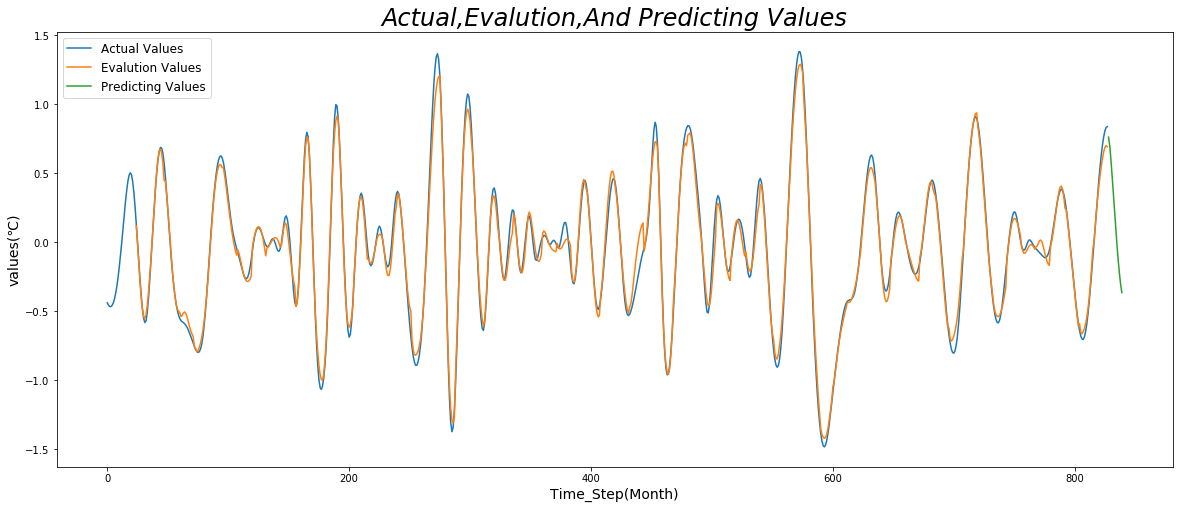

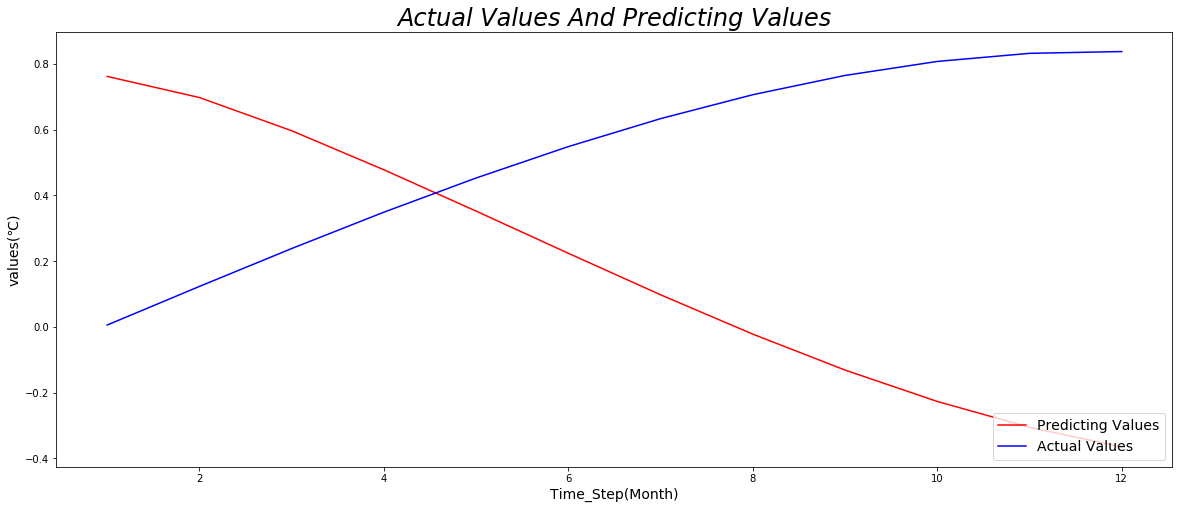

(828,)


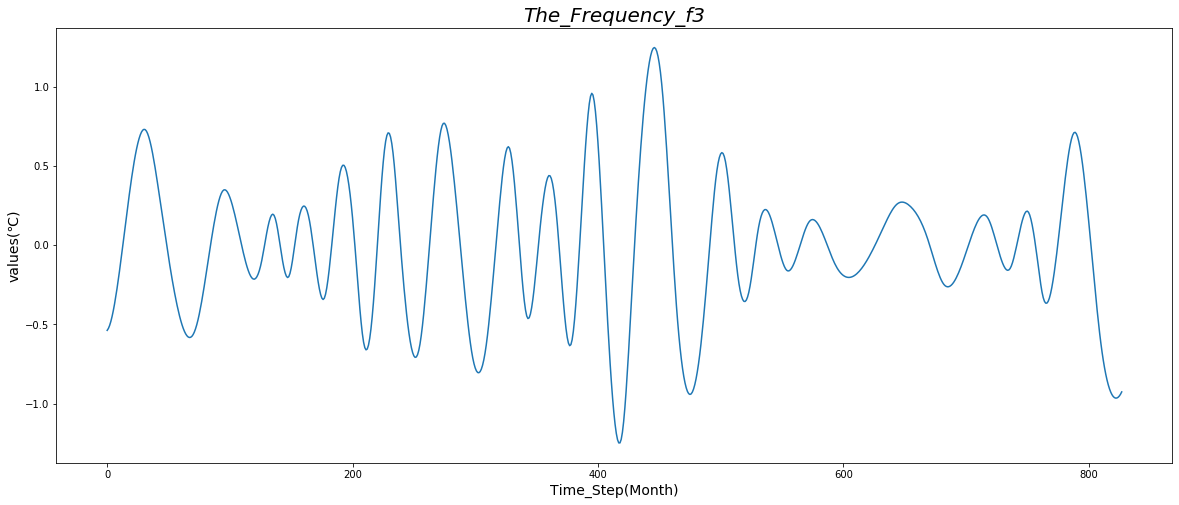

[[[-0.88131]
  [-0.90671]
  [-0.92735]
  [-0.94342]
  [-0.95507]
  [-0.96249]
  [-0.96584]
  [-0.96529]
  [-0.96101]
  [-0.95309]
  [-0.94162]
  [-0.92675]]]
[-0.88131 -0.90671 -0.92735 -0.94342 -0.95507 -0.96249 -0.96584 -0.96529
 -0.96101 -0.95309 -0.94162 -0.92675]
(792, 24, 1)
Epoch 1/200
 - 21s - loss: 0.1608
Epoch 2/200
 - 8s - loss: 0.1205
Epoch 3/200
 - 8s - loss: 0.0868
Epoch 4/200
 - 8s - loss: 0.0663
Epoch 5/200
 - 8s - loss: 0.0546
Epoch 6/200
 - 8s - loss: 0.0453
Epoch 7/200
 - 8s - loss: 0.0334
Epoch 8/200
 - 8s - loss: 0.0274
Epoch 9/200
 - 8s - loss: 0.0275
Epoch 10/200
 - 8s - loss: 0.0213
Epoch 11/200
 - 8s - loss: 0.0214
Epoch 12/200
 - 8s - loss: 0.0215
Epoch 13/200
 - 8s - loss: 0.0207
Epoch 14/200
 - 8s - loss: 0.0210
Epoch 15/200
 - 8s - loss: 0.0271
Epoch 16/200
 - 8s - loss: 0.0220
Epoch 17/200
 - 8s - loss: 0.0173
Epoch 18/200
 - 8s - loss: 0.0138
Epoch 19/200
 - 8s - loss: 0.0134
Epoch 20/200
 - 8s - loss: 0.0138
Epoch 21/200
 - 8s - loss: 0.0133
Epoch 22/200

(67, 12)
(840,)


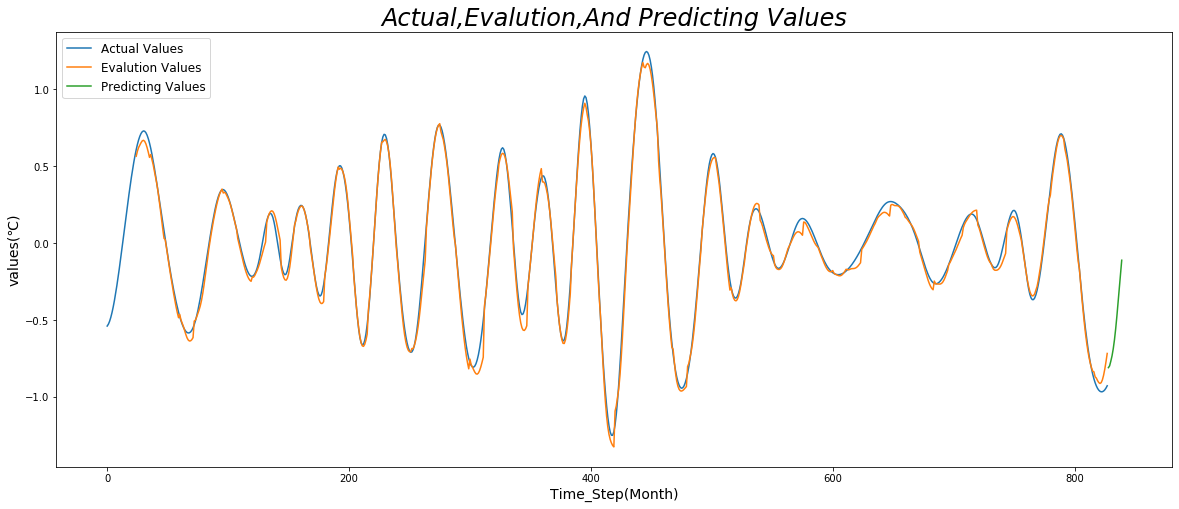

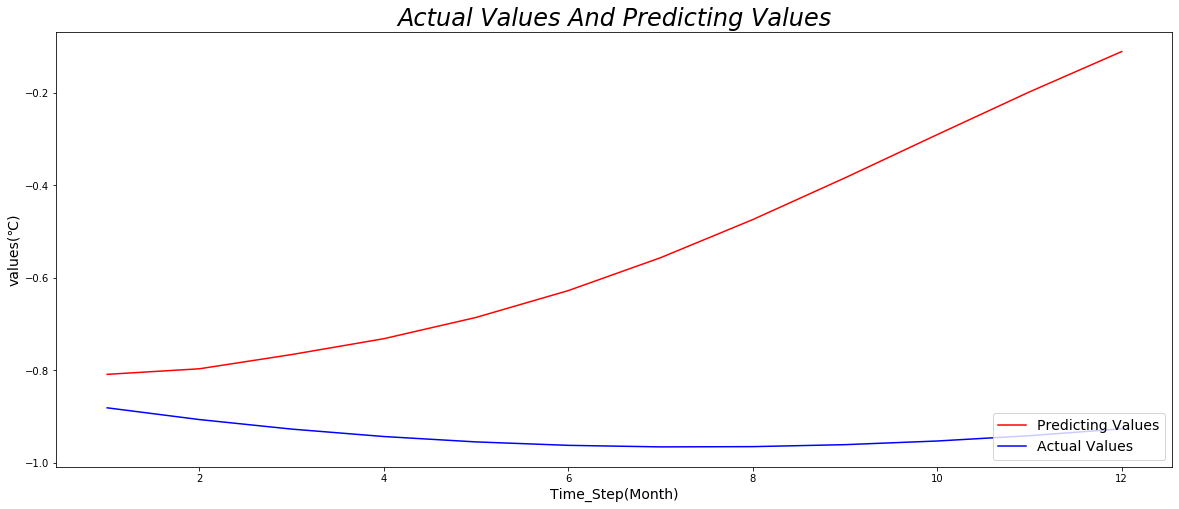

(828,)


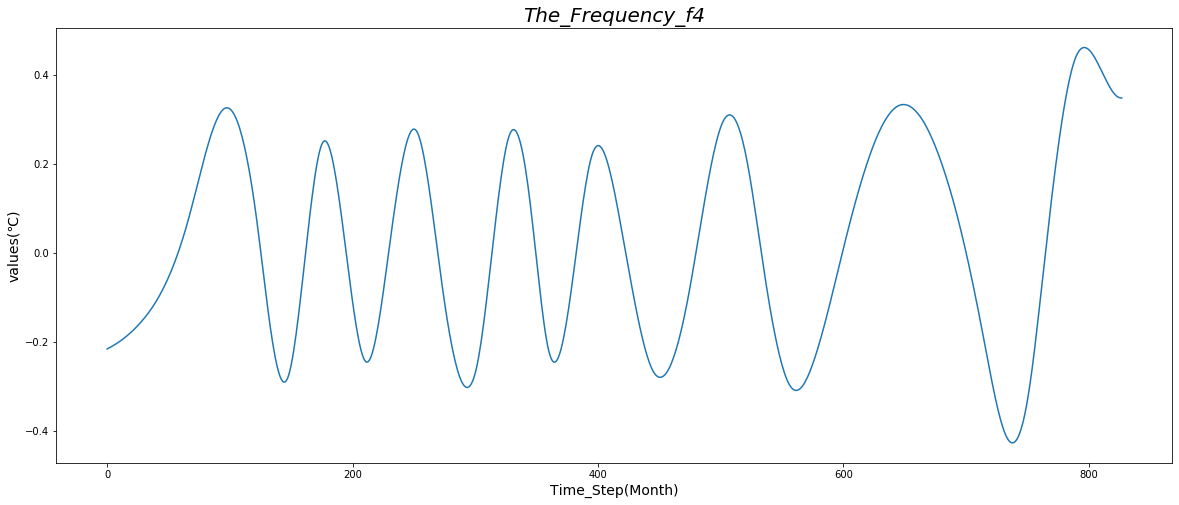

[[[0.37911]
  [0.37411]
  [0.36941]
  [0.36506]
  [0.36112]
  [0.35764]
  [0.35466]
  [0.35226]
  [0.35045]
  [0.34923]
  [0.34856]
  [0.34841]]]
[0.37911 0.37411 0.36941 0.36506 0.36112 0.35764 0.35466 0.35226 0.35045
 0.34923 0.34856 0.34841]
(792, 24, 1)
Epoch 1/200
 - 28s - loss: 0.0383
Epoch 2/200
 - 10s - loss: 0.0112
Epoch 3/200
 - 10s - loss: 0.0063
Epoch 4/200
 - 9s - loss: 0.0046
Epoch 5/200
 - 9s - loss: 0.0039
Epoch 6/200
 - 9s - loss: 0.0024
Epoch 7/200
 - 9s - loss: 0.0023
Epoch 8/200
 - 9s - loss: 0.0025
Epoch 9/200
 - 10s - loss: 0.0020
Epoch 10/200
 - 11s - loss: 0.0018
Epoch 11/200
 - 10s - loss: 0.0020
Epoch 12/200
 - 10s - loss: 0.0025
Epoch 13/200
 - 9s - loss: 0.0020
Epoch 14/200
 - 9s - loss: 0.0017
Epoch 15/200
 - 10s - loss: 0.0014
Epoch 16/200
 - 10s - loss: 0.0017
Epoch 17/200
 - 9s - loss: 0.0014
Epoch 18/200
 - 11s - loss: 0.0014
Epoch 19/200
 - 10s - loss: 0.0015
Epoch 20/200
 - 9s - loss: 0.0015
Epoch 21/200
 - 9s - loss: 0.0013
Epoch 22/200
 - 9s - loss:

(67, 12)
(840,)


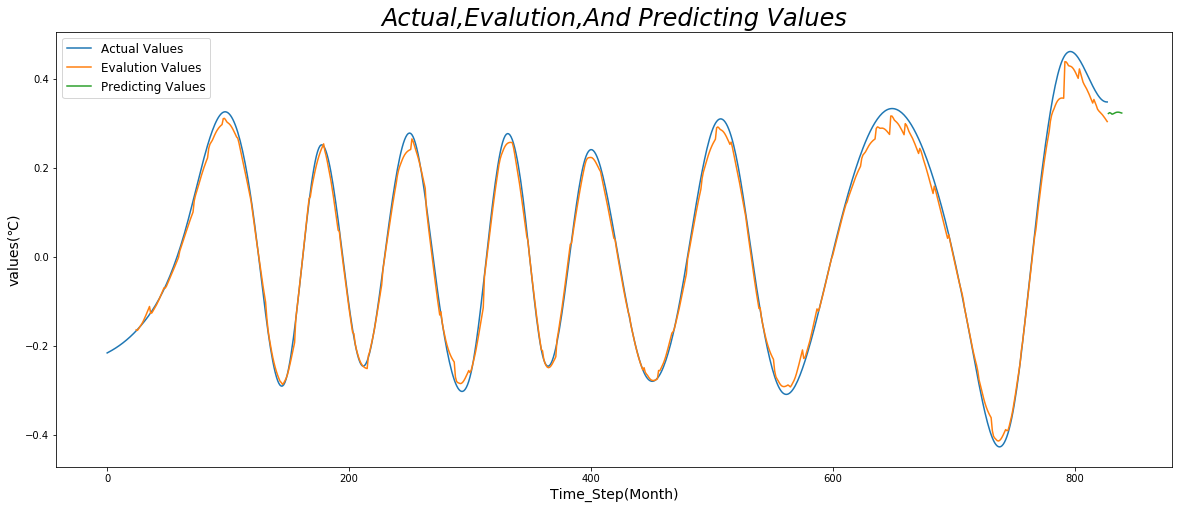

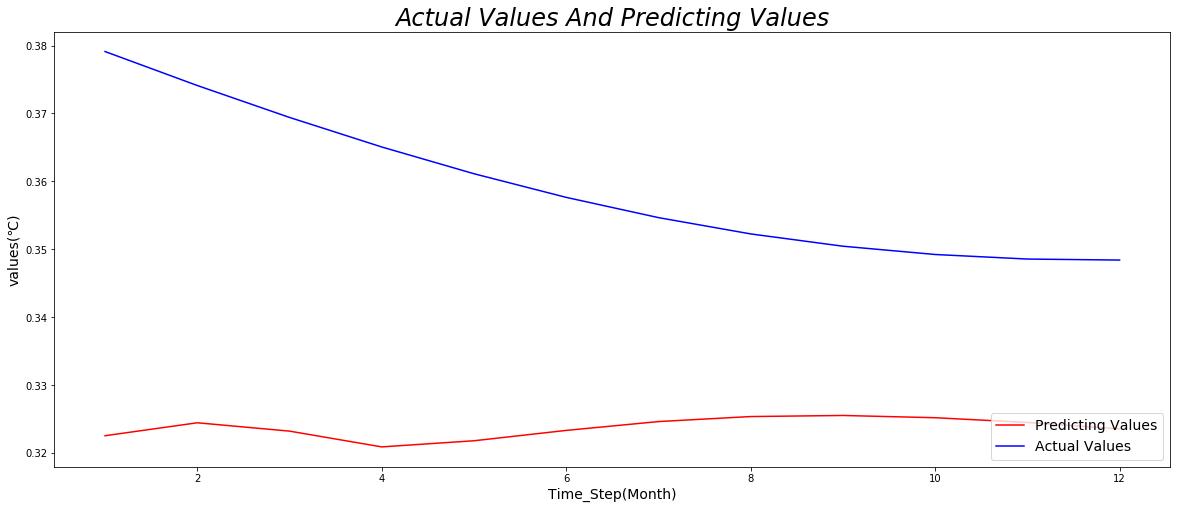

(828,)


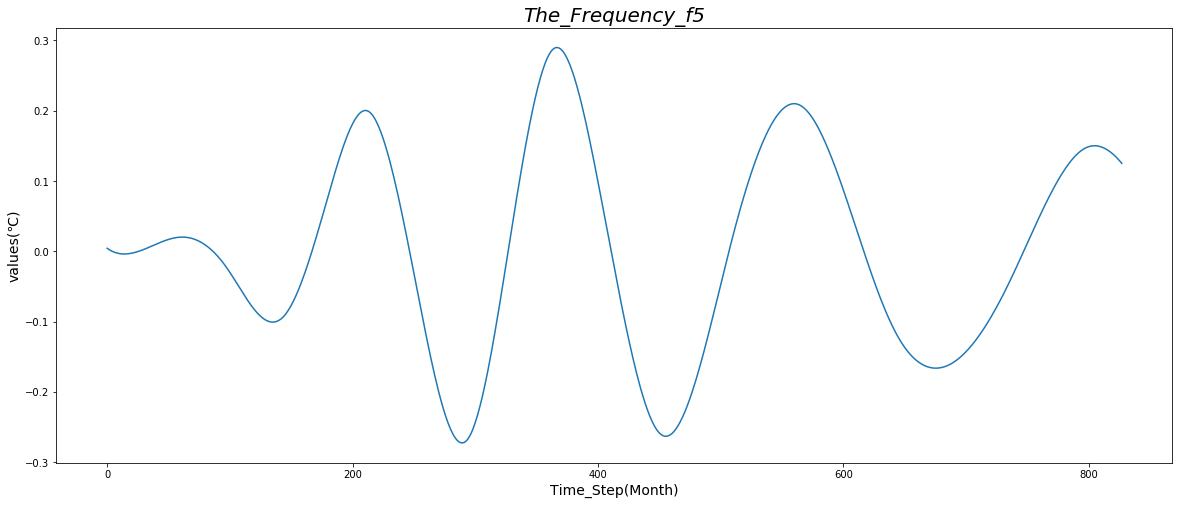

[[[0.1436 ]
  [0.14239]
  [0.14109]
  [0.13969]
  [0.1382 ]
  [0.13661]
  [0.13494]
  [0.13318]
  [0.13133]
  [0.1294 ]
  [0.12738]
  [0.12528]]]
[0.1436  0.14239 0.14109 0.13969 0.1382  0.13661 0.13494 0.13318 0.13133
 0.1294  0.12738 0.12528]
(792, 24, 1)
Epoch 1/200
 - 24s - loss: 0.0134
Epoch 2/200
 - 10s - loss: 0.0052
Epoch 3/200
 - 10s - loss: 0.0015
Epoch 4/200
 - 12s - loss: 9.0898e-04
Epoch 5/200
 - 11s - loss: 6.2232e-04
Epoch 6/200
 - 10s - loss: 5.1373e-04
Epoch 7/200
 - 10s - loss: 4.5714e-04
Epoch 8/200
 - 10s - loss: 6.8362e-04
Epoch 9/200
 - 10s - loss: 4.6256e-04
Epoch 10/200
 - 10s - loss: 3.9940e-04
Epoch 11/200
 - 10s - loss: 3.3911e-04
Epoch 12/200
 - 13s - loss: 3.5115e-04
Epoch 13/200
 - 11s - loss: 3.7807e-04
Epoch 14/200
 - 10s - loss: 3.7815e-04
Epoch 15/200
 - 10s - loss: 3.3330e-04
Epoch 16/200
 - 10s - loss: 4.0487e-04
Epoch 17/200
 - 12s - loss: 4.2367e-04
Epoch 18/200
 - 11s - loss: 3.2353e-04
Epoch 19/200
 - 10s - loss: 3.6545e-04
Epoch 20/200
 - 10s - 

the prediction values are:[[0.11752592]
 [0.1173363 ]
 [0.11612361]
 [0.11328428]
 [0.11055637]
 [0.10774925]
 [0.10483927]
 [0.1018576 ]
 [0.09886579]
 [0.09592623]
 [0.09309146]
 [0.09040066]]
the real values are:[0.1436  0.14239 0.14109 0.13969 0.1382  0.13661 0.13494 0.13318 0.13133
 0.1294  0.12738 0.12528]
12
[0.1436]
[[0.11752592]]
0.000679857633668699
12
[0.14239]
[[0.1173363]]
0.0006276877335841841
12
[0.14109]
[[0.11612361]]
0.0006233206673401645
12
[0.13969]
[[0.11328428]]
0.0006972619226943112
12
[0.1382]
[[0.11055637]]
0.0007641701960915447
12
[0.13661]
[[0.10774925]]
0.0008329431179362645
12
[0.13494]
[[0.10483927]]
0.0009060542266787846
12
[0.13318]
[[0.1018576]]
0.0009810925791163797
12
[0.13133]
[[0.09886579]]
0.0010539247909861012
12
[0.1294]
[[0.09592623]]
0.0011204936003389309
12
[0.12738]
[[0.09309146]]
0.0011757041068487892
12
[0.12528]
[[0.09040066]]
0.0012165684601336978
(67, 12)
(840,)


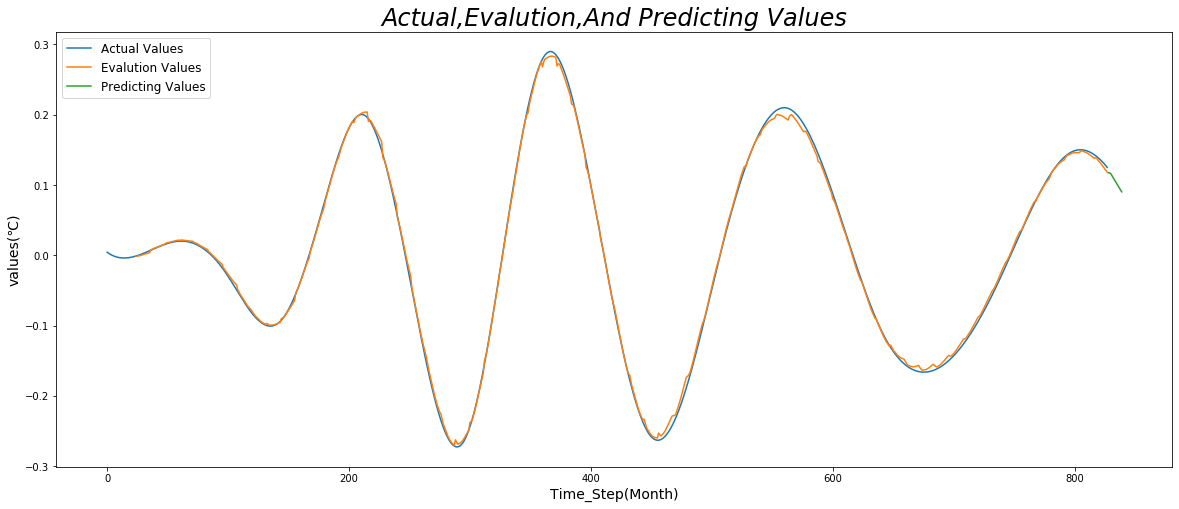

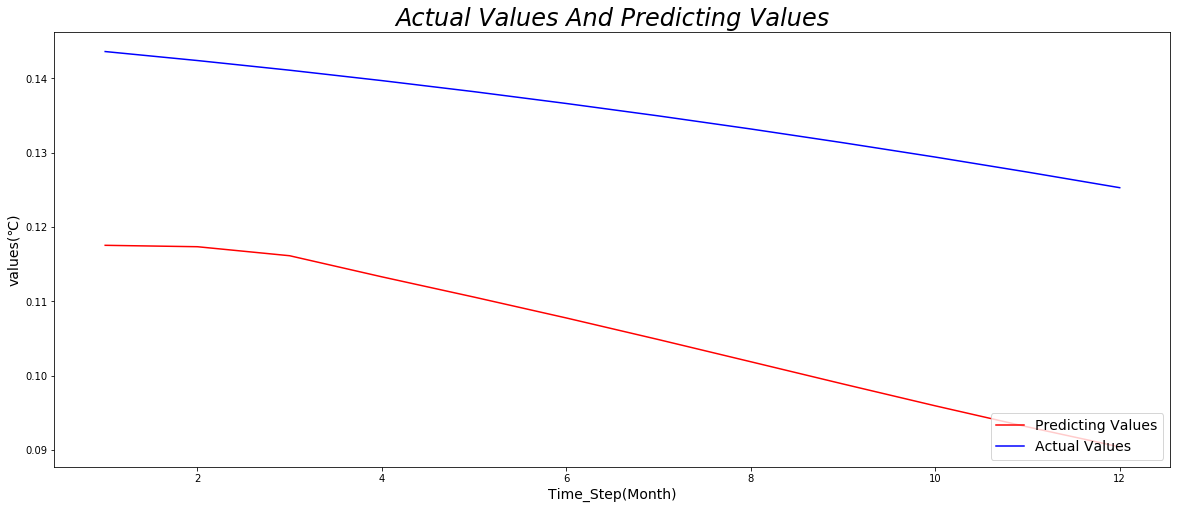

(828,)


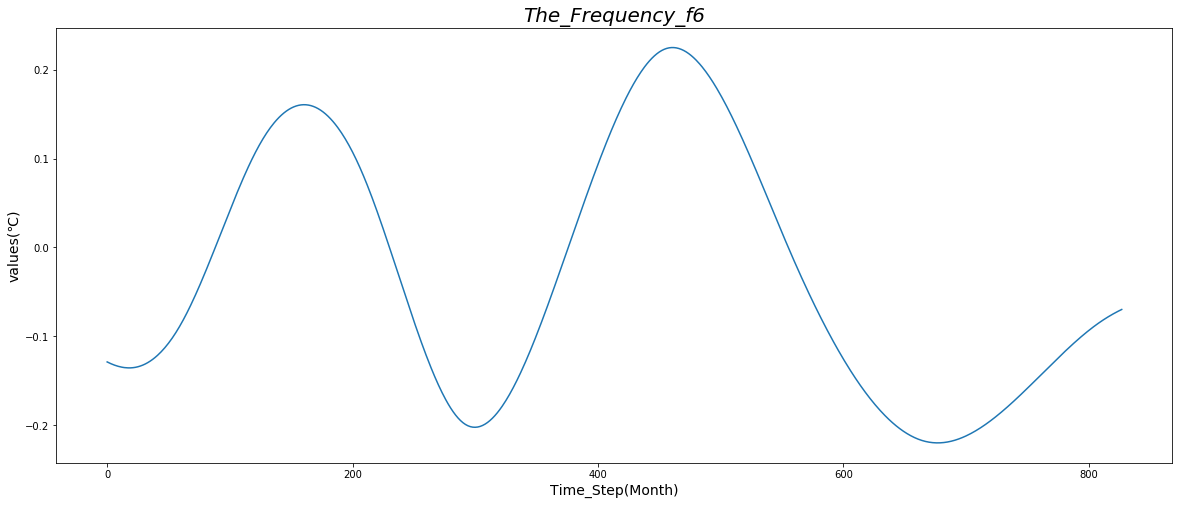

[[[-0.078087]
  [-0.077258]
  [-0.076445]
  [-0.075649]
  [-0.074869]
  [-0.074105]
  [-0.073357]
  [-0.072625]
  [-0.071909]
  [-0.071208]
  [-0.070523]
  [-0.069853]]]
[-0.078087 -0.077258 -0.076445 -0.075649 -0.074869 -0.074105 -0.073357
 -0.072625 -0.071909 -0.071208 -0.070523 -0.069853]
(792, 24, 1)
Epoch 1/200
 - 25s - loss: 0.0083
Epoch 2/200
 - 9s - loss: 0.0030
Epoch 3/200
 - 8s - loss: 0.0014
Epoch 4/200
 - 8s - loss: 6.6735e-04
Epoch 5/200
 - 8s - loss: 4.4598e-04
Epoch 6/200
 - 9s - loss: 3.4450e-04
Epoch 7/200
 - 9s - loss: 3.0772e-04
Epoch 8/200
 - 9s - loss: 3.2099e-04
Epoch 9/200
 - 8s - loss: 3.1799e-04
Epoch 10/200
 - 8s - loss: 3.2251e-04
Epoch 11/200
 - 10s - loss: 2.8861e-04
Epoch 12/200
 - 11s - loss: 3.1806e-04
Epoch 13/200
 - 10s - loss: 2.3985e-04
Epoch 14/200
 - 11s - loss: 2.7539e-04
Epoch 15/200
 - 10s - loss: 2.8125e-04
Epoch 16/200
 - 11s - loss: 2.7380e-04
Epoch 17/200
 - 10s - loss: 2.3785e-04
Epoch 18/200
 - 8s - loss: 2.2143e-04
Epoch 19/200
 - 8s - lo

the prediction values are:[[-0.0682767 ]
 [-0.06840938]
 [-0.06756479]
 [-0.06660751]
 [-0.06568532]
 [-0.06473799]
 [-0.06379675]
 [-0.06289981]
 [-0.06207709]
 [-0.06134672]
 [-0.06071645]
 [-0.06018608]]
the real values are:[-0.078087 -0.077258 -0.076445 -0.075649 -0.074869 -0.074105 -0.073357
 -0.072625 -0.071909 -0.071208 -0.070523 -0.069853]
12
[-0.078087]
[[-0.0682767]]
9.624192020999074e-05
12
[-0.077258]
[[-0.06840938]]
7.82980175572024e-05
12
[-0.076445]
[[-0.06756479]]
7.885807758689913e-05
12
[-0.075649]
[[-0.06660751]]
8.174863033261583e-05
12
[-0.074869]
[[-0.06568532]]
8.433989806124072e-05
12
[-0.074105]
[[-0.06473799]]
8.774086700038981e-05
12
[-0.073357]
[[-0.06379675]]
9.13983570958594e-05
12
[-0.072625]
[[-0.06289981]]
9.45792610959011e-05
12
[-0.071909]
[[-0.06207709]]
9.666645141341468e-05
12
[-0.071208]
[[-0.06134672]]
9.724475193475943e-05
12
[-0.070523]
[[-0.06071645]]
9.616834563325062e-05
12
[-0.069853]
[[-0.06018608]]
9.344933001726221e-05
(67, 12)
(840,)


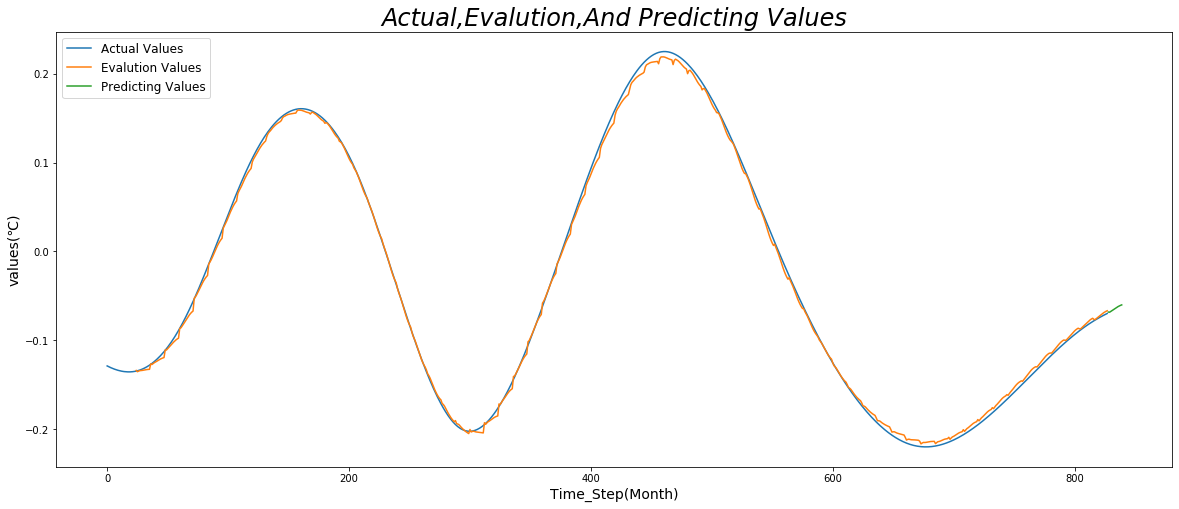

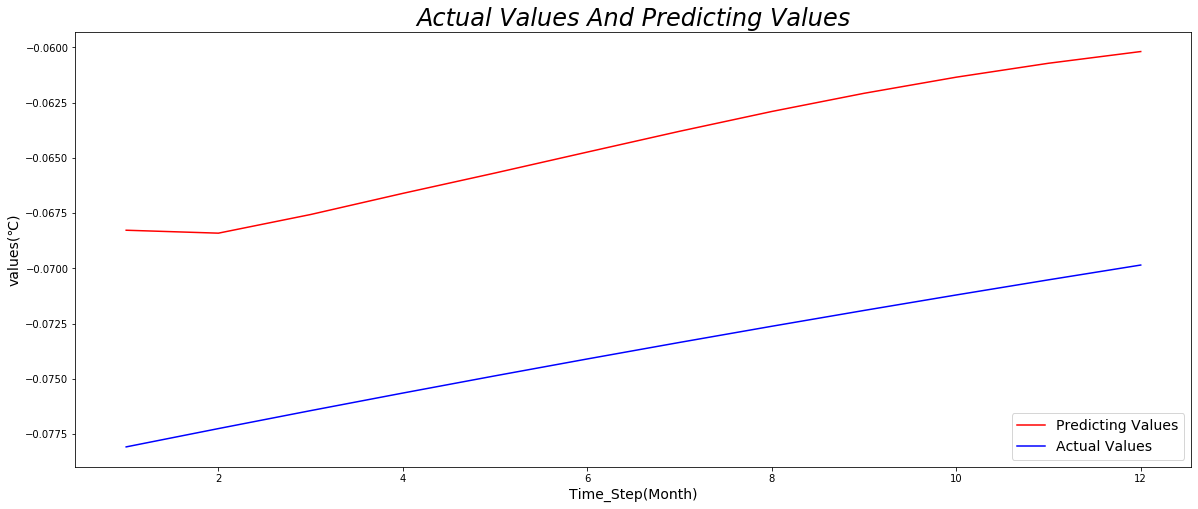

(828,)


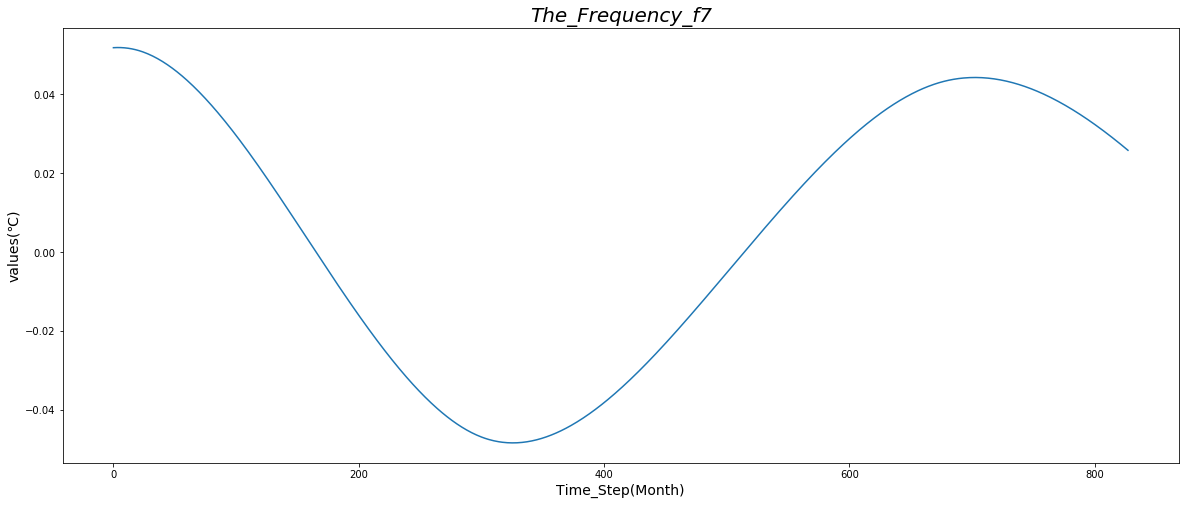

[[[0.02861 ]
  [0.028363]
  [0.028114]
  [0.027865]
  [0.027614]
  [0.027362]
  [0.027108]
  [0.026853]
  [0.026597]
  [0.026339]
  [0.026081]
  [0.025821]]]
[0.02861  0.028363 0.028114 0.027865 0.027614 0.027362 0.027108 0.026853
 0.026597 0.026339 0.026081 0.025821]
(792, 24, 1)
Epoch 1/200
 - 27s - loss: 7.0420e-04
Epoch 2/200
 - 11s - loss: 2.1792e-04
Epoch 3/200
 - 11s - loss: 1.3025e-04
Epoch 4/200
 - 11s - loss: 8.5484e-05
Epoch 5/200
 - 11s - loss: 7.1986e-05
Epoch 6/200
 - 11s - loss: 6.7243e-05
Epoch 7/200
 - 11s - loss: 5.6869e-05
Epoch 8/200
 - 12s - loss: 5.1238e-05
Epoch 9/200
 - 11s - loss: 4.4915e-05
Epoch 10/200
 - 11s - loss: 4.1158e-05
Epoch 11/200
 - 11s - loss: 4.6849e-05
Epoch 12/200
 - 12s - loss: 4.2155e-05
Epoch 13/200
 - 12s - loss: 3.8391e-05
Epoch 14/200
 - 12s - loss: 3.6148e-05
Epoch 15/200
 - 11s - loss: 3.0949e-05
Epoch 16/200
 - 11s - loss: 3.5589e-05
Epoch 17/200
 - 12s - loss: 3.7740e-05
Epoch 18/200
 - 11s - loss: 3.0842e-05
Epoch 19/200
 - 12s - los

the prediction values are:[[0.02547837]
 [0.02474345]
 [0.02402589]
 [0.02353021]
 [0.02321333]
 [0.0229431 ]
 [0.02270155]
 [0.02248459]
 [0.02229124]
 [0.02212046]
 [0.02197091]
 [0.02184097]]
the real values are:[0.02861  0.028363 0.028114 0.027865 0.027614 0.027362 0.027108 0.026853
 0.026597 0.026339 0.026081 0.025821]
12
[0.02861]
[[0.02547837]]
9.807103402371144e-06
12
[0.028363]
[[0.02474345]]
1.3101163338837773e-05
12
[0.028114]
[[0.02402589]]
1.671265061994847e-05
12
[0.027865]
[[0.02353021]]
1.87904253733207e-05
12
[0.027614]
[[0.02321333]]
1.9365857885140773e-05
12
[0.027362]
[[0.0229431]]
1.9526661095778116e-05
12
[0.027108]
[[0.02270155]]
1.9416832008805413e-05
12
[0.026853]
[[0.02248459]]
1.9082978901672213e-05
12
[0.026597]
[[0.02229124]]
1.8539574766182687e-05
12
[0.026339]
[[0.02212046]]
1.779610383979248e-05
12
[0.026081]
[[0.02197091]]
1.6892831986639335e-05
12
[0.025821]
[[0.02184097]]
1.5840660786996356e-05
(67, 12)
(840,)


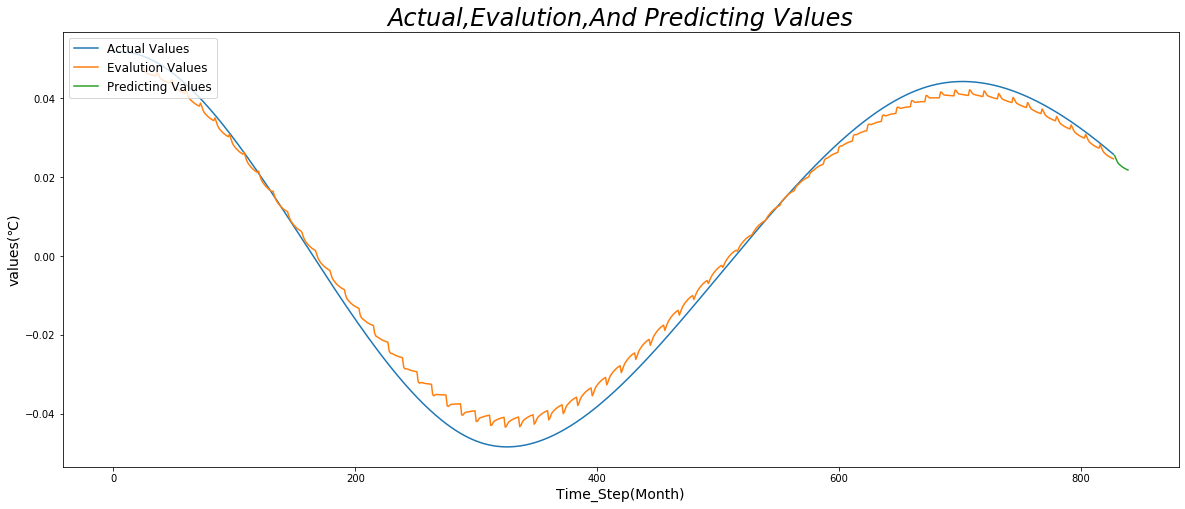

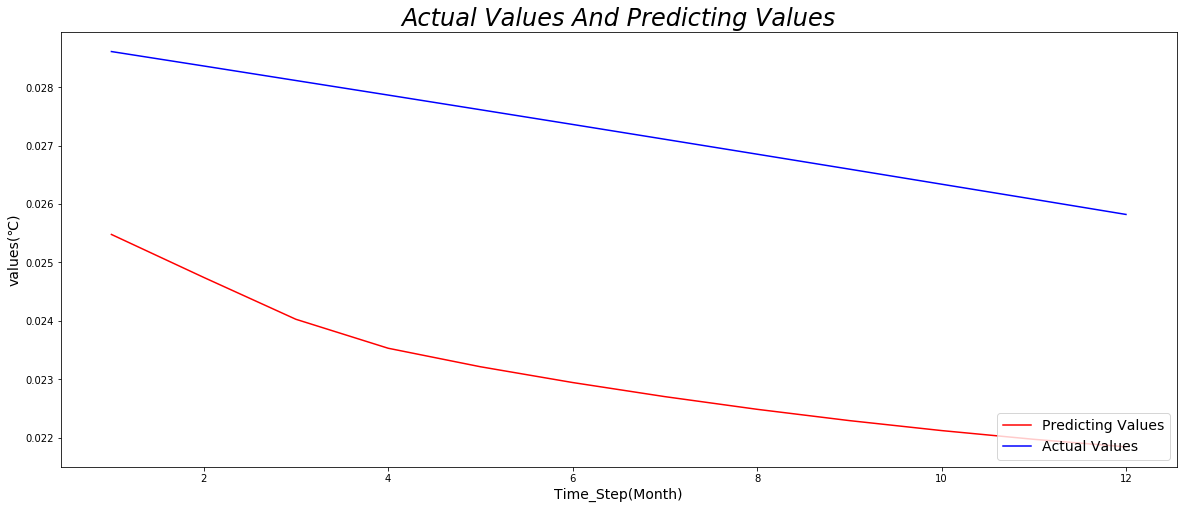

(828,)


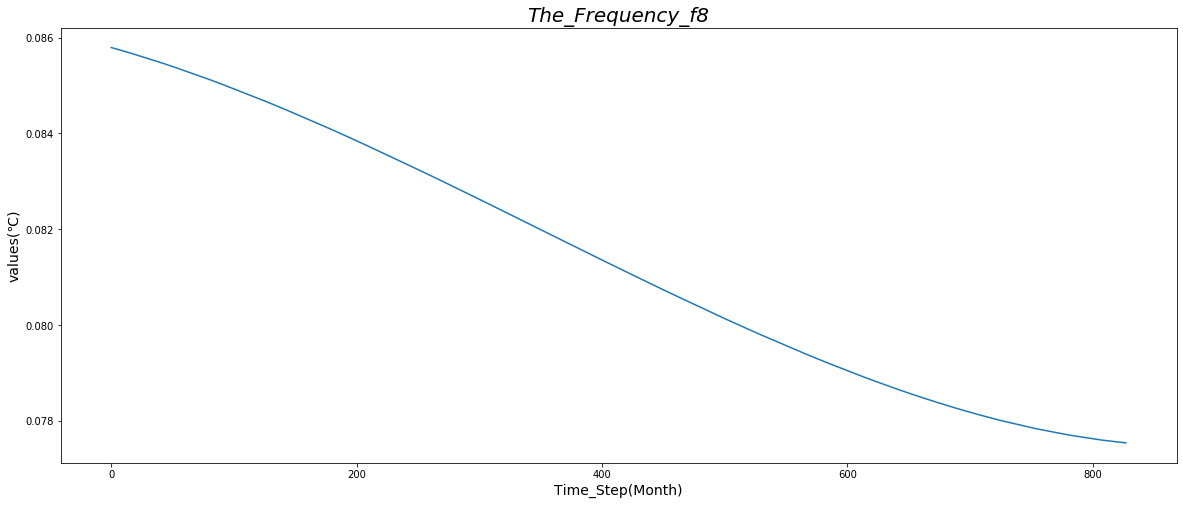

[[[0.077574]
  [0.077571]
  [0.077568]
  [0.077565]
  [0.077562]
  [0.077559]
  [0.077556]
  [0.077554]
  [0.077551]
  [0.077548]
  [0.077546]
  [0.077543]]]
[0.077574 0.077571 0.077568 0.077565 0.077562 0.077559 0.077556 0.077554
 0.077551 0.077548 0.077546 0.077543]
(792, 24, 1)
Epoch 1/200
 - 28s - loss: 6.0010e-04
Epoch 2/200
 - 13s - loss: 1.6847e-05
Epoch 3/200
 - 13s - loss: 9.3294e-06
Epoch 4/200
 - 13s - loss: 7.9568e-06
Epoch 5/200
 - 13s - loss: 7.5309e-06
Epoch 6/200
 - 13s - loss: 7.4401e-06
Epoch 7/200
 - 13s - loss: 7.5889e-06
Epoch 8/200
 - 13s - loss: 7.6670e-06
Epoch 9/200
 - 13s - loss: 7.3383e-06
Epoch 10/200
 - 13s - loss: 7.1646e-06
Epoch 11/200
 - 13s - loss: 7.2522e-06
Epoch 12/200
 - 13s - loss: 6.9511e-06
Epoch 13/200
 - 13s - loss: 6.9184e-06
Epoch 14/200
 - 13s - loss: 7.9653e-06
Epoch 15/200
 - 13s - loss: 7.0550e-06
Epoch 16/200
 - 13s - loss: 6.9637e-06
Epoch 17/200
 - 13s - loss: 6.9940e-06
Epoch 18/200
 - 13s - loss: 6.8929e-06
Epoch 19/200
 - 13s - los

the prediction values are:[[0.07956087]
 [0.07812312]
 [0.07759684]
 [0.07762314]
 [0.07781085]
 [0.07795834]
 [0.07801484]
 [0.07799933]
 [0.07794654]
 [0.07788398]
 [0.07782716]
 [0.07778209]]
the real values are:[0.077574 0.077571 0.077568 0.077565 0.077562 0.077559 0.077556 0.077554
 0.077551 0.077548 0.077546 0.077543]
12
[0.077574]
[[0.07956087]]
3.947646206048206e-06
12
[0.077571]
[[0.07812312]]
3.048309766580259e-07
12
[0.077568]
[[0.07759684]]
8.315029039968096e-10
12
[0.077565]
[[0.07762314]]
3.3807005658626225e-09
12
[0.077562]
[[0.07781085]]
6.19244656602692e-08
12
[0.077559]
[[0.07795834]]
1.5947080839540907e-07
12
[0.077556]
[[0.07801484]]
2.1053705086971673e-07
12
[0.077554]
[[0.07799933]]
1.983197503925869e-07
12
[0.077551]
[[0.07794654]]
1.5644891949640617e-07
12
[0.077548]
[[0.07788398]]
1.1288334543214479e-07
12
[0.077546]
[[0.07782716]]
7.905265542078661e-08
12
[0.077543]
[[0.07778209]]
5.716260697058265e-08
(67, 12)
(840,)


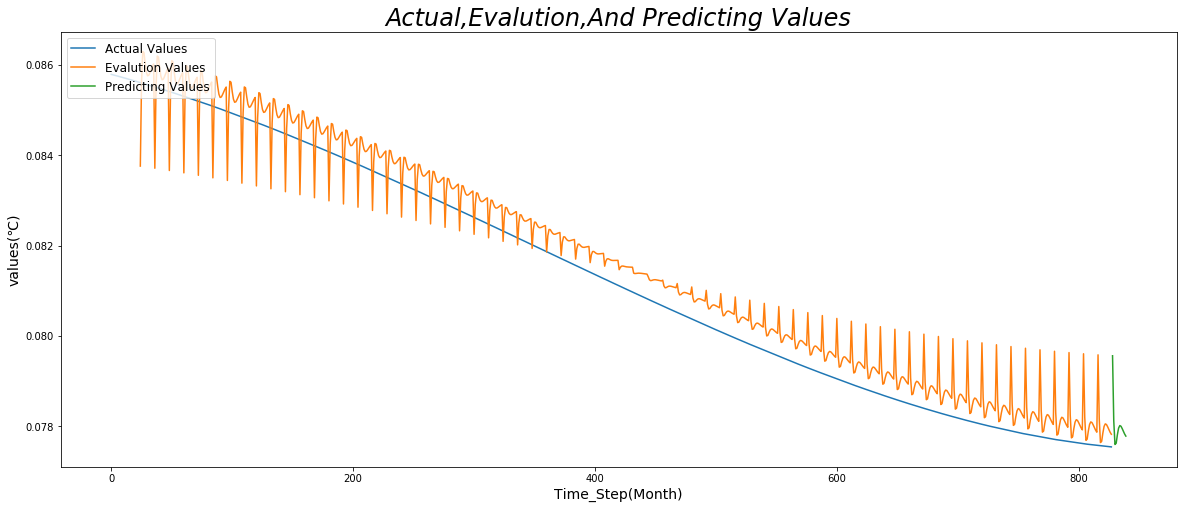

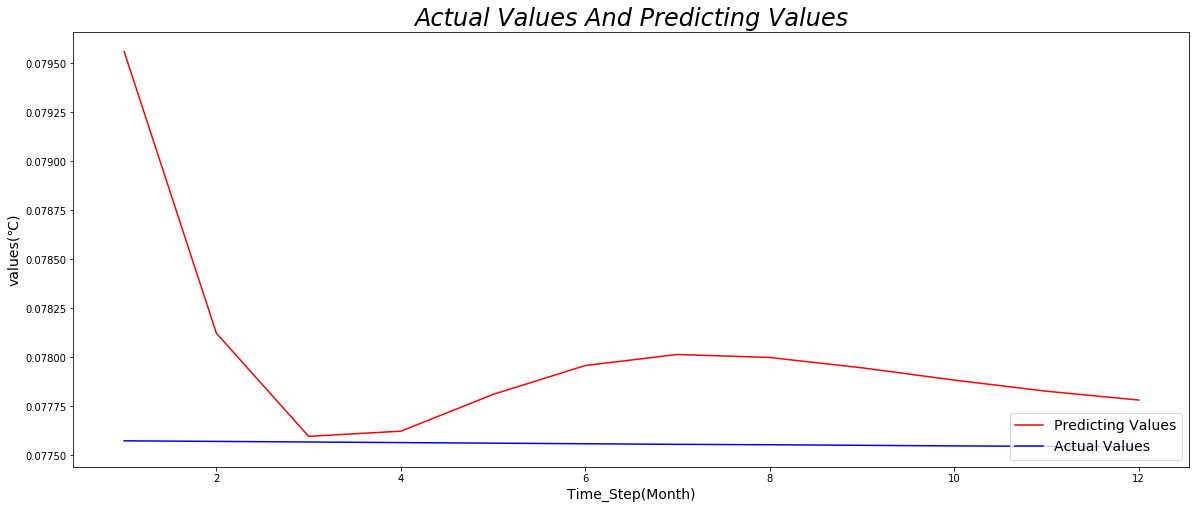

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD_2019')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD_2019')

for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][::]
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD_2019/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    print (test)
    print (test[0].reshape(-1))
    

    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    # it is changed for predicting 2019
    testPredictPlot = np.zeros(840)
    print (testPredictPlot.shape)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(testPredictPlot)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD_2019/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD_2019/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [7]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.07956087]
 [0.07812312]
 [0.07759684]
 [0.07762314]
 [0.07781085]
 [0.07795834]
 [0.07801484]
 [0.07799933]
 [0.07794654]
 [0.07788398]
 [0.07782716]
 [0.07778209]]
[array([-0.28373  , -0.20753  , -0.069358 ,  0.029479 ,  0.18765  ,
        0.20383  , -0.017003 , -0.14515  , -0.14641  ,  0.0092768,
        0.1346   ,  0.035037 ]), array([-0.29143 , -0.354   , -0.38141 , -0.36968 , -0.31534 , -0.21508 ,
       -0.071875,  0.086582,  0.22809 ,  0.32458 ,  0.36537 ,  0.34646 ]), array([0.0056482, 0.12307  , 0.23839  , 0.34909  , 0.45314  , 0.54868  ,
       0.63381  , 0.70665  , 0.76531  , 0.80793  , 0.83261  , 0.83806  ]), array([-0.88131, -0.90671, -0.92735, -0.94342, -0.95507, -0.96249,
       -0.96584, -0.96529, -0.96101, -0.95309, -0.94162, -0.92675]), array([0.37911, 0.37411, 0.36941, 0.36506, 0.36112, 0.35764, 0.35466,
       0.35226, 0.35045, 0.34923, 0.34856, 0.34841]), array([0.1436 , 0.14239, 0.14109, 0.13969, 0.1382 , 0.13661, 0.13494,
       0.13318, 0.13133, 0.1294 , 0.1

In [8]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
[[-0.28373  ]
 [-0.20753  ]
 [-0.069358 ]
 [ 0.029479 ]
 [ 0.18765  ]
 [ 0.20383  ]
 [-0.017003 ]
 [-0.14515  ]
 [-0.14641  ]
 [ 0.0092768]
 [ 0.1346   ]
 [ 0.035037 ]]
[[-0.28]
 [-0.21]
 [-0.07]
 [ 0.03]
 [ 0.19]
 [ 0.2 ]
 [-0.02]
 [-0.15]
 [-0.15]
 [ 0.01]
 [ 0.13]
 [ 0.04]]
-----------------------------------
observe value:[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
[[-0.57516  ]
 [-0.56153  ]
 [-0.450768 ]
 [-0.340201 ]
 [-0.12769  ]
 [-0.01125  ]
 [-0.088878 ]
 [-0.058568 ]
 [ 0.08168  ]
 [ 0.3338568]
 [ 0.49997  ]
 [ 0.381497 ]]
[[-0.58]
 [-0.56]
 [-0.45]
 [-0.34]
 [-0.13]
 [-0.01]
 [-0.09]
 [-0.06]
 [ 0.08]
 [ 0.33]
 [ 0.5 ]
 [ 0.38]]
-----------------------------------
observe value:[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70

In [9]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[ 0.07907514 -0.01809913 -0.13244478 -0.18707097 -0.16719389 -0.08573839
  0.01417866  0.08386122  0.10050503  0.071152    0.02213629 -0.01944342]
[ 0.07907514 -0.01809913 -0.13244478 -0.18707097 -0.16719389 -0.08573839
  0.01417866  0.08386122  0.10050503  0.071152    0.02213629 -0.01944342]
the 1 frequence:
predicted_value:[ 0.21828759  0.147892    0.07097823 -0.0176369  -0.11335167 -0.20358105
 -0.26840165 -0.28963473 -0.25903857 -0.18255582 -0.07913116  0.02658836]
[ 0.29736272  0.12979287 -0.06146655 -0.20470787 -0.28054556 -0.28931944
 -0.254223   -0.20577352 -0.15853354 -0.11140382 -0.05699488  0.00714493]
the 2 frequence:
predicted_value:[ 0.76237345  0.6981122   0.59707755  0.4782085   0.3524224   0.22401871
  0.09769951 -0.02208273 -0.13141887 -0.22692522 -0.3057056  -0.36531517]
[ 1.05973617  0.82790506  0.535611    0.27350064  0.07187682 -0.06530073
 -0.15652349 -0.22785625 -0.2899524  -0.33832905 -0.362

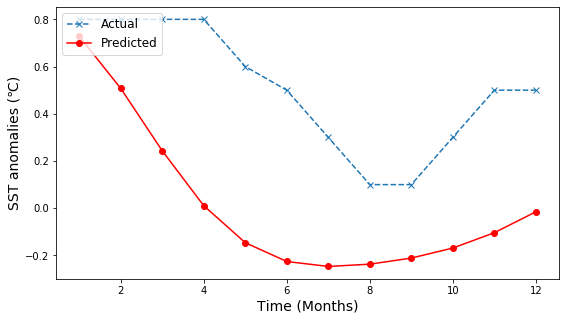

In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np

if(os.path.exists('12_months_valiation_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_valiation_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

actual_values_2019=[0.8,0.8,0.8,0.8,0.6,0.5,0.3,0.1,0.1,0.3,0.5,0.5]
predicted_values_2019=predicted_values
plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,np.array(actual_values_2019).reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,np.array(predicted_values_2019).reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 
plt.show()